In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dsets 
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

#hyperparameters
batchsize=64 #batch-size of 64
imgsize=64 #image of size (64,64)

#creating transformations so that the image is ready to be fed to the neural network
transform=transforms.Compose([transforms.Resize(imgsize),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # Applying transformation(resizing,tensor conversion and normalization) to the image  

#loading the dataset
dataset=dsets.ImageFolder(root='mydata',transform=transform)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=True,num_workers=3) #Dataloader helps is to load data in specific batch size and whether we want to shuffle it or not and num_workers=-1 means it uses all the parallel processes available

print('Dataloader executed')
#GANs use a different type of weight initialization called Xavier's Initialization
def weights(network):
	classname=network.__class__.__name__ # this line searches for the name of the class in the network defination
	if classname.find('Conv') !=-1: #this line finds the occurance of the strin g 'Conv' in the network function's defination and if the string 'Conv' is present then it activates the if loop
		with torch.no_grad():
			network.weight.normal_(0.0,0.02)
	elif classname.find('BatchNorm')!=-1: #similar operation as above
		with torch.no_grad():
			network.weight.data.normal_(1.0,0.02)
		# network.bias.data.fill_(0)
# Defining the generator network

class generator(nn.Module):
	def __init__(self):
		super(generator,self).__init__() # this line passes all the goodness of nn.module in the generator class that we defined 
		self.main=nn.Sequential(nn.ConvTranspose2d(100,512,4,1,0,bias=False), #100 is the input noise vector, 512 are the new feature maps,4 is the size of kernel(4,4),1 is the stride of the kernel,0 is the padding and bias is set to false
			nn.ReLU(True), #to introduce non-linearity
			nn.BatchNorm2d(512), #normalizing all the new feature maps
			nn.ConvTranspose2d(512,256,4,2,1,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(256),
			nn.ConvTranspose2d(256,128,4,2,1,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(128),
			nn.ConvTranspose2d(128,64,4,2,1,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(64),
			nn.ConvTranspose2d(64,3,4,2,1,bias=False),
			nn.Tanh() #Tanh is selected here because the dataset has values between -1 and 1 , also Tanh is bounded, this bounded and symmetrical nature of the function helps the model to learn faster 
			)
	def forward(self,x):
		output=self.main(x)
		return output
netG=generator()
netG.cuda()
netG.apply(weights) #applying weights initizlization function on the generator function


class discriminator(nn.Module):
	def __init__(self):
		super(discriminator,self).__init__() #to activate inheritance
		self.main=nn.Sequential(
			nn.Conv2d(3,64,4,2,1,bias=False),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(64,128,4,2,1,bias=False),
			nn.BatchNorm2d(128),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(128,256,4,2,1,bias=False),
			nn.BatchNorm2d(256),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(256,512,4,2,1,bias=False),
			nn.BatchNorm2d(512),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(512,1,4,1,0,bias=False),
			nn.Sigmoid()
			)
	def forward(self,x):
		output=self.main(x)
		return output.view(-1) # .view(-1) is used to reshape the convouled image and flatten it along a single axis.

print('Networks defined')
netD=discriminator()
netD.cuda()
netD.apply(weights) #applying weights initizlization function on the generator function

run=150 ### number of epochs



###### TRAINING THE GANs ########
criterion = nn.BCELoss()
optimizerD=optim.Adam(netD.parameters(),lr=0.001,betas=(0.5,0.999)) #the value of betas is selected from experimentation
optimizerG=optim.Adam(netG.parameters(),lr=0.001,betas=(0.5,0.999))
err_dis=[]
err_gen=[]
print('Loop starting now')
for epoch in range(run):	
	for i,data in enumerate(dataloader,0): #0 in the enumerate parenthesis is just the starting value we want 'i' to take.
		netD.zero_grad() #clearing gradient buffers and setting it to zero for every new batch



		###Training the discriminator network on real images

		images,_=data #_ here holds the labels of the images. As we dont want the labels here we just throw it away
		real=Variable(images.cuda()) #to compute gradients, we need to wrap the image with a Variable class
		real_targets=Variable(torch.ones(real.size()[0]).cuda()) #setting real tagerts to 1s and deciding the size on basis of how many images are present in real variable
		output=netD(real) #computing the outputs through discriminator which will be a number between 0 and 1 giving probablity of image being real or fake
		error_real=criterion(output,real_targets) #calculating the error for real images and their output given by our discriminator network

		###Training the images on fake network
		noise=Variable(torch.randn(real.size()[0],100,1,1).cuda()) #this line can be interpreted like a matrix which has real.size()[0] number of rows and 100 number of columns(technically feature maps) and each column has a 1x1 array
		fake_output=netG(noise)  #generator uses this noise vector to generate a mini-batch of fakeimages
		fake_target=Variable(torch.zeros(real.size()[0]).cuda())#instantiating the fake target as 0s
		output=netD(fake_output.detach()) #the fake_output is a torch variable and it contains the data as well as the gradients, but we dont want this gradients so we will only use the data and for that we use .detach() method
		error_fake=criterion(output,fake_target) #calculating the error of fake images with wrt their output

		error_total=error_real+error_fake
		error_total.backward() #this line back-propagates the error 
		optimizerD.step()      #this line updates the parameters of netD

		##Training the generator
		netG.zero_grad() #initializing the gradients of generaotr neural net
		output=netD(fake_output) #notice here we didnt use .detach() because we want to update the weights of generator unlike previously where we were updating the weights of discriminator, because the fake_output is generated by generator and not discriminator
		target=Variable(torch.ones(real.size()[0]).cuda()) #here we defined targets as 1s because we want the generator to generate near perfect images which the discriminator should predict as real( or target =1) 
		error_gen=criterion(output,target)
		error_gen.backward()
		optimizerG.step()
		print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, run, i, len(dataloader), error_total.data, error_gen.data))
		if i%10000==0:
			vutils.save_image(real, '%s/real_samples.png' % "./results", normalize = True)
			fake = netG(noise)
			vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize = True)
	err_dis.append(torch.sum(error_total))
	err_gen.append(torch.sum(error_gen))

print('Training Completed')

Dataloader executed
Networks defined
Loop starting now
[0/150][0/8] Loss_D: 1.2884 Loss_G: 14.9014
[0/150][1/8] Loss_D: 0.0396 Loss_G: 12.8868
[0/150][2/8] Loss_D: 0.0614 Loss_G: 21.8036
[0/150][3/8] Loss_D: 0.4924 Loss_G: 0.4253
[0/150][4/8] Loss_D: 12.8836 Loss_G: 29.8412
[0/150][5/8] Loss_D: 0.4748 Loss_G: 28.8472
[0/150][6/8] Loss_D: 1.1916 Loss_G: 23.2354
[0/150][7/8] Loss_D: 0.0000 Loss_G: 19.5109
[1/150][0/8] Loss_D: 0.0076 Loss_G: 14.8842
[1/150][1/8] Loss_D: 0.6951 Loss_G: 19.0559
[1/150][2/8] Loss_D: 0.0000 Loss_G: 19.0782
[1/150][3/8] Loss_D: 0.0491 Loss_G: 17.2223
[1/150][4/8] Loss_D: 0.0001 Loss_G: 14.4326
[1/150][5/8] Loss_D: 0.0062 Loss_G: 10.7733
[1/150][6/8] Loss_D: 0.0339 Loss_G: 8.2544
[1/150][7/8] Loss_D: 0.1943 Loss_G: 10.9990
[2/150][0/8] Loss_D: 0.0010 Loss_G: 12.5731
[2/150][1/8] Loss_D: 0.0063 Loss_G: 10.9119
[2/150][2/8] Loss_D: 0.0430 Loss_G: 12.1104
[2/150][3/8] Loss_D: 0.1219 Loss_G: 24.8368
[2/150][4/8] Loss_D: 5.1901 Loss_G: 0.0357
[2/150][5/8] Loss_D: 16

[23/150][1/8] Loss_D: 1.6451 Loss_G: 11.2204
[23/150][2/8] Loss_D: 8.7095 Loss_G: 1.5905
[23/150][3/8] Loss_D: 0.8573 Loss_G: 0.8994
[23/150][4/8] Loss_D: 1.0390 Loss_G: 3.5491
[23/150][5/8] Loss_D: 1.8526 Loss_G: 0.2149
[23/150][6/8] Loss_D: 2.4080 Loss_G: 3.2354
[23/150][7/8] Loss_D: 1.1055 Loss_G: 0.9353
[24/150][0/8] Loss_D: 1.1599 Loss_G: 4.1118
[24/150][1/8] Loss_D: 1.3554 Loss_G: 0.3682
[24/150][2/8] Loss_D: 2.8933 Loss_G: 5.8726
[24/150][3/8] Loss_D: 3.1503 Loss_G: 1.9187
[24/150][4/8] Loss_D: 1.0201 Loss_G: 1.9925
[24/150][5/8] Loss_D: 0.8600 Loss_G: 3.1200
[24/150][6/8] Loss_D: 1.0880 Loss_G: 0.6771
[24/150][7/8] Loss_D: 1.5225 Loss_G: 4.6954
[25/150][0/8] Loss_D: 1.7471 Loss_G: 2.3219
[25/150][1/8] Loss_D: 1.0954 Loss_G: 3.2186
[25/150][2/8] Loss_D: 0.4421 Loss_G: 2.9021
[25/150][3/8] Loss_D: 0.4382 Loss_G: 2.7229
[25/150][4/8] Loss_D: 0.6129 Loss_G: 5.5702
[25/150][5/8] Loss_D: 2.6958 Loss_G: 1.2058
[25/150][6/8] Loss_D: 1.8214 Loss_G: 5.3441
[25/150][7/8] Loss_D: 3.8665 Lo

[46/150][3/8] Loss_D: 1.5589 Loss_G: 0.3391
[46/150][4/8] Loss_D: 1.6323 Loss_G: 2.2866
[46/150][5/8] Loss_D: 1.6170 Loss_G: 0.4514
[46/150][6/8] Loss_D: 1.1839 Loss_G: 1.7729
[46/150][7/8] Loss_D: 1.1301 Loss_G: 1.0616
[47/150][0/8] Loss_D: 1.0161 Loss_G: 1.0160
[47/150][1/8] Loss_D: 1.1493 Loss_G: 1.4986
[47/150][2/8] Loss_D: 1.2332 Loss_G: 0.3928
[47/150][3/8] Loss_D: 1.4580 Loss_G: 3.1927
[47/150][4/8] Loss_D: 2.0864 Loss_G: 0.2704
[47/150][5/8] Loss_D: 1.5497 Loss_G: 2.0573
[47/150][6/8] Loss_D: 1.2208 Loss_G: 0.6604
[47/150][7/8] Loss_D: 1.1927 Loss_G: 2.4120
[48/150][0/8] Loss_D: 1.1947 Loss_G: 0.6201
[48/150][1/8] Loss_D: 0.6577 Loss_G: 2.3775
[48/150][2/8] Loss_D: 0.7048 Loss_G: 2.9325
[48/150][3/8] Loss_D: 0.9087 Loss_G: 1.3428
[48/150][4/8] Loss_D: 1.4639 Loss_G: 4.5918
[48/150][5/8] Loss_D: 2.3796 Loss_G: 0.3831
[48/150][6/8] Loss_D: 1.9269 Loss_G: 3.4321
[48/150][7/8] Loss_D: 1.7906 Loss_G: 0.5791
[49/150][0/8] Loss_D: 1.6314 Loss_G: 2.6968
[49/150][1/8] Loss_D: 1.4041 Los

[69/150][5/8] Loss_D: 2.0962 Loss_G: 2.6574
[69/150][6/8] Loss_D: 1.4297 Loss_G: 0.9469
[69/150][7/8] Loss_D: 1.0878 Loss_G: 1.9228
[70/150][0/8] Loss_D: 1.0779 Loss_G: 1.1226
[70/150][1/8] Loss_D: 1.1611 Loss_G: 1.7591
[70/150][2/8] Loss_D: 1.0240 Loss_G: 0.9757
[70/150][3/8] Loss_D: 1.2950 Loss_G: 3.2326
[70/150][4/8] Loss_D: 1.4905 Loss_G: 1.5996
[70/150][5/8] Loss_D: 1.2311 Loss_G: 3.7535
[70/150][6/8] Loss_D: 1.5904 Loss_G: 0.9295
[70/150][7/8] Loss_D: 1.2203 Loss_G: 3.3454
[71/150][0/8] Loss_D: 1.6156 Loss_G: 0.4062
[71/150][1/8] Loss_D: 1.2766 Loss_G: 3.0477
[71/150][2/8] Loss_D: 1.0482 Loss_G: 0.9690
[71/150][3/8] Loss_D: 1.3772 Loss_G: 3.6661
[71/150][4/8] Loss_D: 1.7940 Loss_G: 0.3989
[71/150][5/8] Loss_D: 1.4680 Loss_G: 3.5260
[71/150][6/8] Loss_D: 1.4412 Loss_G: 0.6246
[71/150][7/8] Loss_D: 1.2634 Loss_G: 3.1363
[72/150][0/8] Loss_D: 1.2858 Loss_G: 0.7029
[72/150][1/8] Loss_D: 1.0485 Loss_G: 2.8781
[72/150][2/8] Loss_D: 0.9276 Loss_G: 1.8431
[72/150][3/8] Loss_D: 1.8320 Los

[92/150][7/8] Loss_D: 1.3723 Loss_G: 0.8013
[93/150][0/8] Loss_D: 1.1127 Loss_G: 2.4530
[93/150][1/8] Loss_D: 1.1971 Loss_G: 0.6100
[93/150][2/8] Loss_D: 1.4926 Loss_G: 1.9550
[93/150][3/8] Loss_D: 1.3395 Loss_G: 0.9810
[93/150][4/8] Loss_D: 1.1126 Loss_G: 1.7918
[93/150][5/8] Loss_D: 1.2370 Loss_G: 0.9909
[93/150][6/8] Loss_D: 1.7790 Loss_G: 1.3220
[93/150][7/8] Loss_D: 1.4900 Loss_G: 1.0272
[94/150][0/8] Loss_D: 1.0742 Loss_G: 2.6568
[94/150][1/8] Loss_D: 1.5295 Loss_G: 0.3786
[94/150][2/8] Loss_D: 1.3513 Loss_G: 3.8598
[94/150][3/8] Loss_D: 1.8701 Loss_G: 0.2879
[94/150][4/8] Loss_D: 2.4750 Loss_G: 2.3793
[94/150][5/8] Loss_D: 1.8739 Loss_G: 0.9727
[94/150][6/8] Loss_D: 1.2724 Loss_G: 0.8849
[94/150][7/8] Loss_D: 1.1711 Loss_G: 1.7039
[95/150][0/8] Loss_D: 1.2945 Loss_G: 0.8344
[95/150][1/8] Loss_D: 1.6396 Loss_G: 1.4170
[95/150][2/8] Loss_D: 2.0049 Loss_G: 0.6446
[95/150][3/8] Loss_D: 1.3823 Loss_G: 1.2791
[95/150][4/8] Loss_D: 1.2592 Loss_G: 1.0290
[95/150][5/8] Loss_D: 1.1950 Los

[115/150][6/8] Loss_D: 1.4379 Loss_G: 3.2591
[115/150][7/8] Loss_D: 2.3609 Loss_G: 0.5233
[116/150][0/8] Loss_D: 0.6862 Loss_G: 2.5492
[116/150][1/8] Loss_D: 0.8289 Loss_G: 4.5436
[116/150][2/8] Loss_D: 1.5969 Loss_G: 0.2664
[116/150][3/8] Loss_D: 2.5746 Loss_G: 3.3604
[116/150][4/8] Loss_D: 1.3988 Loss_G: 1.2243
[116/150][5/8] Loss_D: 1.0294 Loss_G: 1.0261
[116/150][6/8] Loss_D: 1.0182 Loss_G: 2.4575
[116/150][7/8] Loss_D: 1.4133 Loss_G: 0.4378
[117/150][0/8] Loss_D: 0.9878 Loss_G: 3.2145
[117/150][1/8] Loss_D: 1.3146 Loss_G: 0.4221
[117/150][2/8] Loss_D: 1.2817 Loss_G: 3.9365
[117/150][3/8] Loss_D: 1.8339 Loss_G: 0.6484
[117/150][4/8] Loss_D: 1.0574 Loss_G: 3.0928
[117/150][5/8] Loss_D: 0.9903 Loss_G: 1.2653
[117/150][6/8] Loss_D: 0.8323 Loss_G: 2.5563
[117/150][7/8] Loss_D: 1.0364 Loss_G: 2.0690
[118/150][0/8] Loss_D: 0.9995 Loss_G: 1.9116
[118/150][1/8] Loss_D: 1.2444 Loss_G: 2.9864
[118/150][2/8] Loss_D: 0.6364 Loss_G: 1.6923
[118/150][3/8] Loss_D: 0.7627 Loss_G: 3.2277
[118/150][

[138/150][4/8] Loss_D: 1.4115 Loss_G: 0.8993
[138/150][5/8] Loss_D: 1.4449 Loss_G: 1.6989
[138/150][6/8] Loss_D: 1.3558 Loss_G: 0.6243
[138/150][7/8] Loss_D: 1.0716 Loss_G: 2.3004
[139/150][0/8] Loss_D: 1.4209 Loss_G: 0.6471
[139/150][1/8] Loss_D: 1.5336 Loss_G: 1.8803
[139/150][2/8] Loss_D: 1.3381 Loss_G: 0.9423
[139/150][3/8] Loss_D: 1.3145 Loss_G: 2.3614
[139/150][4/8] Loss_D: 1.3989 Loss_G: 0.6650
[139/150][5/8] Loss_D: 1.2470 Loss_G: 1.6937
[139/150][6/8] Loss_D: 1.2660 Loss_G: 1.3413
[139/150][7/8] Loss_D: 1.0437 Loss_G: 1.5941
[140/150][0/8] Loss_D: 1.1400 Loss_G: 1.4009
[140/150][1/8] Loss_D: 0.9840 Loss_G: 2.3730
[140/150][2/8] Loss_D: 2.0306 Loss_G: 1.0871
[140/150][3/8] Loss_D: 1.0882 Loss_G: 2.5700
[140/150][4/8] Loss_D: 1.5286 Loss_G: 0.4440
[140/150][5/8] Loss_D: 1.5146 Loss_G: 2.8577
[140/150][6/8] Loss_D: 1.6639 Loss_G: 0.9265
[140/150][7/8] Loss_D: 0.9310 Loss_G: 1.9175
[141/150][0/8] Loss_D: 1.0395 Loss_G: 2.2852
[141/150][1/8] Loss_D: 1.2423 Loss_G: 1.3604
[141/150][

Text(0, 0.5, 'Loss')

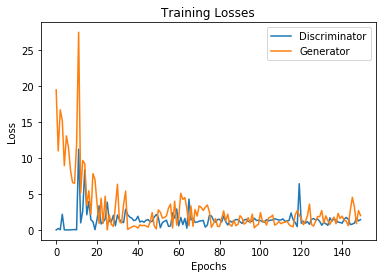

In [7]:
plt.plot(range(run),err_dis,label='Discriminator')
plt.plot(range(run),err_gen,label='Generator')
plt.legend()
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [9]:
plt.savefig('loss_trend.jpg')

<Figure size 432x288 with 0 Axes>

In [3]:
torch.save(netD,'Discriminator network')
torch.save(netG,'Generator network')

C:\Users\DHARMIK\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\DHARMIK\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [4]:
# a=torch.load('Discriminator network') #use this line to save model in variable 'a'